In [1]:
import pandas as pd
import os

import utils

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

#from IPython.core.debugger import set_trace
#set_trace()


In [2]:
import warnings

warnings.filterwarnings('ignore')
    # Your code that causes the warning


In [3]:
%xmode Standard

In [4]:
%%time

inp_filename = 'pi_pull_m6_2024-01-14.csv'
data_dir = 'data'

date_cutoff = pd.to_datetime('2023-12-31')

raw_data = pd.read_csv(os.path.join(data_dir, inp_filename))

CPU times: user 1min 7s, sys: 22.5 s, total: 1min 30s
Wall time: 1min 44s


In [5]:
def split_dataframe_to_csv(df, rows_per_file, output_prefix):
    """
    Splits a DataFrame into multiple CSV files with a specified number of rows in each.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    rows_per_file (int): The number of rows per each output file.
    output_prefix (str): The prefix for the output file names.
    """
    # Calculate the number of files needed
    num_files = len(df) // rows_per_file + int(len(df) % rows_per_file > 0)

    for i in range(num_files):
        start_row = i * rows_per_file
        end_row = start_row + rows_per_file
        # Slice the DataFrame
        df_slice = df.iloc[start_row:end_row]
        # Save the slice to a CSV file
        df_slice.to_csv(f"{output_prefix}_{i:05d}.csv", index=False)
        print(f"Saved file: {output_prefix}_{i:05d}.csv")

# Example usage
# df = pd.DataFrame(...) # your large DataFrame
# split_dataframe_to_csv(df, 250000, 'output_file')


In [6]:
raw_data.tail()

,PT_5347.PV,PT_5347.PV.TIME,ST_5347.PV,ST_5347.PV.TIME,SIC_5345.OUT,SIC_5345.OUT.TIME,TT_5347.PV,TT_5347.PV.TIME,WT_5347.PV,WT_5347.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME,PT_5352.PV,PT_5352.PV.TIME,SIC_5350.OUT,SIC_5350.OUT.TIME,ST_5352.PV,ST_5352.PV.TIME,TT_5352.PV,TT_5352.PV.TIME,WT_5352.PV,WT_5352.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT.TIME,PT_5357.PV,PT_5357.PV.TIME,SIC_5355.OUT,SIC_5355.OUT.TIME,ST_5357.PV,ST_5357.PV.TIME,TT_5357.PV,TT_5357.PV.TIME,WT_5357.PV,WT_5357.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT.TIME,PT_5362.PV,PT_5362.PV.TIME,SIC_5360.OUT,SIC_5360.OUT.TIME,ST_5362.PV,ST_5362.PV.TIME,TT_5362.PV,TT_5362.PV.TIME,WT_5362.PV,WT_5362.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT.TIME
12505844,5719.261719,2024-01-14 04:50:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12505845,5680.183594,2024-01-14 04:50:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12505846,5829.853516,2024-01-14 04:50:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12505847,5886.433594,2024-01-14 04:50:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12505848,5607.876953,2024-01-14 04:50:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import pandas as pd

def merge_data_with_time(df, window=None, agg_func='mean', verbose=False, get_series_list=False):
    """
    Merge data columns with their corresponding time columns in a DataFrame.

    :param df: pandas DataFrame with data and time columns
    :param time_frame: time period for resampling (e.g., '1H' for 1 hour)
    :param agg_func: aggregation function (e.g., 'mean', 'sum', 'max')
    :return: pandas DataFrame after merging
    """
    # Initialize an empty list to store the series
    raw_series_list = []
    processed_series_list = []

    # Determine the aggregation function
    if isinstance(agg_func, str):
        agg_func = getattr(pd.core.groupby.SeriesGroupBy, agg_func)

    # Identify and process each data column
    for column in df.columns:
        # Check if the column is a data column (not a time column)
        if not column.endswith('.TIME'):
            # Get the corresponding time column
            time_column = column + '.TIME'

            
            # Check if the time column exists
            if time_column in df.columns:
                #print(column, time_column)
                # Create a Series with the data column values and time column as index
                series = pd.Series(df[column].values, index=pd.to_datetime(df[time_column]), name=column)
                raw_series_list.append(series)

                #else:
                #    # Group by index (time) and calculate the mean for duplicate times
                series = series.groupby(level=0).max()
#                series = series.resample('5T').mean()
                if window:
                    series = series.rolling(window=window).mean()
                if verbose:
                    print(series.head())    
                processed_series_list.append(series)
    try:
        # Merge all series with an outer join
        merged_df = pd.concat(processed_series_list, axis=1, join='outer')
    except Exception as e:
        print(f'error trying to merge dataframe\nerror: {e}')
        if get_series_list:
            return None, raw_series_list
        else:
            return None

    if get_series_list:
        return merged_df, raw_series_list
    else:
        return merged_df

# Example usage:
# Assume 'dataframe' is your existing DataFrame
# For default behavior
# merged_dataframe = merge_data_with_time(dataframe)

# For resampling every hour and summing values
# merged_dataframe = merge_data_with_time(dataframe, time_frame='1H', agg_func='sum')


In [8]:
def format_elapsed_time(start, end):
    """
    Format the elapsed time between two datetime objects into a human-readable string.

    :param start: The start time (datetime object).
    :param end: The end time (datetime object).
    :return: A formatted string representing the elapsed time.
    """
    elapsed = end - start
    days = elapsed.days
    hours, remainder = divmod(elapsed.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    if days > 0:
        return f"{days}d {hours}h {minutes}m {seconds}s"
    elif hours > 0:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes > 0:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"

In [9]:
#%%time

import utils

# takes about 2 minutes - 1/20/24

#inp_filename = 'EX1-6-month.csv'
data_dir = 'data'

field_mappings = {}
#time_
ex_data = {}
processed_data = {}
collected_series = {}

for extruder in ['EX2', 'EX3', 'EX4']:
 #   print(extruder)
#    breakpoint()
    '''
    ex_name_mapping = pd.read_csv(os.path.join(data_dir, f'{extruder}-6-month.csv'), 
                               delimiter='\t',
                               encoding='utf-16',
                               nrows=1)

    field_mappings[extruder] = dict(zip(ex_name_mapping.iloc[0], ex_name_mapping.columns ))
    

    #print(extruder)
    #print(name_mappings[extruder])


   # for field_key in name_mappings[extruder]:

    col_mapping = {key : key.split(' (')[0] for key, value in field_mappings[extruder].items() if key != 'Time'}

#    for raw_colname in col_mapping.keys():
#        field_mappings[extruder + '_col2col'] = 

    field_mappings[extruder + '_column_map'] = col_mapping
    
    raw_fieldnames = sorted(col_mapping.values())
    time_keys = [fieldname + '.TIME' for fieldname in raw_fieldnames]
        
    #print(keys_filtered)
    #print(time_keys)

    keys_of_interest = sorted(raw_fieldnames + time_keys)
    ''';

    filepath = os.path.join(data_dir, f'{extruder}-6-month.csv')
    keys_of_interest, time_keys, field_mapping, column_mapping, raw_fieldnames = utils.get_extruder_metadata(filepath)
    field_mappings[extruder], field_mappings[f'{extruder}_column_map'] = field_mapping, column_mapping

    ex_data[extruder] = raw_data[keys_of_interest]

    merged_df, series_list = utils.merge_data_with_time(
        ex_data[extruder], verbose=False, window='5T', get_series_list=True
    )
    

    for raw_colname in field_mappings[f'{extruder}_column_map'].keys():
        merged_df[field_mappings[extruder][raw_colname]] = merged_df[field_mappings[f'{extruder}_column_map'][raw_colname]]


    
    
    processed_colnames = list(field_mappings[extruder].values())
    processed_colnames.remove('Date and Time')
    merged_df = merged_df[processed_colnames]

    processed_df = utils.preprocess_data(merged_df)

    break
    
    processed_data[extruder] = processed_df
    collected_series[extruder] = series_list
    
    for tk in time_keys:
        ex_data[extruder][tk] = pd.to_datetime(ex_data[extruder][tk])

#        field_key = tk.replace('.TIME', '')

#    print()
    #ex_data[extruder] = raw_data[keys_filtered]

AttributeError: 'function' object has no attribute 'diff'

In [26]:
import datetime
import tqdm
tqdm.tqdm.pandas()

def time_until_next_true(bool_series):
    """
    For each datetime index in the series, calculates the time until the next occurrence
    where the series is True.
    
    :param bool_series: A boolean series with a datetime index.
    :return: A series with the time difference until the next True value.
    """
    # Find indices where the condition is True
    true_indices = bool_series.index[bool_series]

    # Function to find time until next True timestamp
    def find_time_until_next_true(current_index):
        future_indices = true_indices[true_indices > current_index]
        return future_indices[0] - current_index if not future_indices.empty else pd.NaT

    # Apply the function to each index
    time_differences = bool_series.index.to_series().progress_apply(find_time_until_next_true)

    return time_differences.apply(lambda x: x.total_seconds() / 3600)

def time_until_next_true_efficient(bool_series):
    """
    Efficiently calculates the time until the next occurrence where the series is True.

    :param bool_series: A boolean series with a datetime index.
    :return: A series with the time difference until the next True value.
    """
    # Convert bool_series to a series of cumulative counts of True values
    cum_true_counts = bool_series.cumsum()

    # Prepare an array to hold the time differences
    time_diffs = pd.Series(index=bool_series.index, dtype='timedelta64[ns]')

    # Find the index of the next True value for each element
    for idx, count in tqdm.tqdm(cum_true_counts.items()):
        # Find the next greater count
        next_true_idx = cum_true_counts[cum_true_counts > count].index.min()
        if pd.notna(next_true_idx):
            # Calculate the time difference
            time_diffs[idx] = next_true_idx - idx
        else:
            # No more True values after this index
            time_diffs[idx] = pd.NaT

    return time_diffs.dt.total_seconds() / 3600

def preprocess_data(df, output_var='Extruder Pressure', output_threshold=5500):
    start_time = datetime.datetime.now()
    processed_df = df.copy()
    print(f'here 0: calculating sample_gap_minutes, time={start_time}')
    processed_df['sample_gap_minutes'] = df.index.to_series().diff().apply(lambda x: x.total_seconds() / 60)
    
    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 1: calculating rolling maxes, elapsed_time={elapsed_str}')
    processed_df['48H_max_gap_backward'] = processed_df['sample_gap_minutes'].rolling('48H').max()
    processed_df['1H_max_gap_forward'] = processed_df[::-1]['sample_gap_minutes'].rolling('1H').max()

    well_sampled_mask = (processed_df['48H_max_gap_backward'] < 15) & (processed_df['1H_max_gap_forward'] < 15)

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 2: filling forward, elapsed_time={elapsed_str}')

    processed_df = processed_df.fillna(method='ffill')

    processed_df['HAZARD_CONDITION'] = processed_df[output_var] > output_threshold

    hazard_indices = processed_df[processed_df['HAZARD_CONDITION']].index

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'here 3: calculating time until next hazard region, elapsed_time={elapsed_str}')
    processed_df['hours_to_hazard'] = time_until_next_true_efficient(processed_df['HAZARD_CONDITION'])

    processed_df['hazard_within_24h'] = processed_df['hours_to_hazard'] < 24

    elapsed_str = format_elapsed_time(start_time, datetime.datetime.now())
    print(f'COMPLETE, elapsed_time={elapsed_str}')

    return processed_df

In [20]:
del raw_data

NameError: name 'raw_data' is not defined

In [ ]:
%%time
import multiprocessing

num_processes = multiprocessing.cup_count()

print(f'Extruder = {extruder}')
processed_df_ex2 = preprocess_data(merged_df)

Extruder = EX2
here 0: calculating sample_gap_minutes, time=2024-01-20 20:54:41.650208
here 1: calculating rolling maxes, elapsed_time=16s
here 2: filling forward, elapsed_time=19s
here 3: calculating time until next hazard region, elapsed_time=20s


1792it [00:42, 45.82it/s]

In [ ]:
processed_df

In [ ]:
processed_df_ex2.to_csv(f'data/{extruder}_processed.csv')

In [42]:
test_data = processed_data['EX1']
test_data.isnull().sum() / len(test_data)

Extruder Pressure                    0.106088
Screw Speed Output                   0.999893
Screw Speed                          0.999998
Extruder Die Temp                    0.997515
Extruder Thrust                      0.657882
Feed Screw Current (Amps)            0.923325
Discharge Conveyor Current (Amps)    0.802384
Discharge Conveyor Speed (%)         0.999998
dtype: float64

In [30]:
print(processed_data['EX1'].min())
print()
print(processed_data['EX1'].max())

Extruder Pressure                   -507.500
Screw Speed Output                    -1.160
Screw Speed                            0.000
Extruder Die Temp                   -391.500
Extruder Thrust                       -3.625
Feed Screw Current (Amps)              0.000
Discharge Conveyor Current (Amps)      0.000
Discharge Conveyor Speed (%)           0.000
dtype: float64

Extruder Pressure                    11712.279297
Screw Speed Output                      31.818451
Screw Speed                             50.000000
Extruder Die Temp                    10752.037109
Extruder Thrust                         99.338196
Feed Screw Current (Amps)                6.920000
Discharge Conveyor Current (Amps)        3.630000
Discharge Conveyor Speed (%)           100.000000
dtype: float64


In [31]:
print(processed_data['EX2'].min())
print()
print(processed_data['EX2'].max())

Extruder Pressure                   -507.500
Screw Speed Output                     0.000
Screw Speed                           -1.160
Extruder Die Temp                   -391.500
Extruder Thrust                       -3.625
Feed Screw Current (Amps)              0.000
Discharge Conveyor Current (Amps)      0.000
Discharge Conveyor Speed (%)           0.000
dtype: float64

Extruder Pressure                    13948.263672
Screw Speed Output                     100.000000
Screw Speed                             31.775078
Extruder Die Temp                    10749.943359
Extruder Thrust                         99.590942
Feed Screw Current (Amps)               15.130000
Discharge Conveyor Current (Amps)        3.860000
Discharge Conveyor Speed (%)            95.000000
dtype: float64


In [32]:
print(processed_data['EX3'].min())
print()
print(processed_data['EX3'].max())

Extruder Pressure                   -271.8750
Screw Speed Output                     0.0000
Screw Speed                           -0.9425
Extruder Die Temp                    -14.5000
Extruder Thrust                       -3.6250
Feed Screw Current (Amps)              0.0000
Discharge Conveyor Current (Amps)      0.0000
Discharge Conveyor Speed (%)           0.0000
dtype: float64

Extruder Pressure                    6152.289062
Screw Speed Output                     35.000000
Screw Speed                            25.793503
Extruder Die Temp                     398.125000
Extruder Thrust                        99.431824
Feed Screw Current (Amps)              11.250000
Discharge Conveyor Current (Amps)       3.940000
Discharge Conveyor Speed (%)          100.000000
dtype: float64


In [35]:
print(processed_data['EX4'].min())
print()
#print(processed_data['EX4'].nlargest(10, processed_data['EX4'].columns))
print(processed_data['EX4'].max())

Extruder Pressure                   -271.8750
Screw Speed Output                     0.0000
Screw Speed                           -0.9425
Extruder Die Temp                    -14.5000
Extruder Thrust                       -3.6250
Feed Screw Current (Amps)              0.0000
Discharge Conveyor Current (Amps)      0.0000
Discharge Conveyor Speed (%)           0.0000
dtype: float64

Extruder Pressure                     6.563420e+03
Screw Speed Output                    7.500000e+01
Screw Speed                          6.952558e-310
Extruder Die Temp                     3.980289e+02
Extruder Thrust                       1.036250e+02
Feed Screw Current (Amps)             1.253000e+01
Discharge Conveyor Current (Amps)     3.970000e+00
Discharge Conveyor Speed (%)          1.000000e+02
dtype: float64


<Axes: >

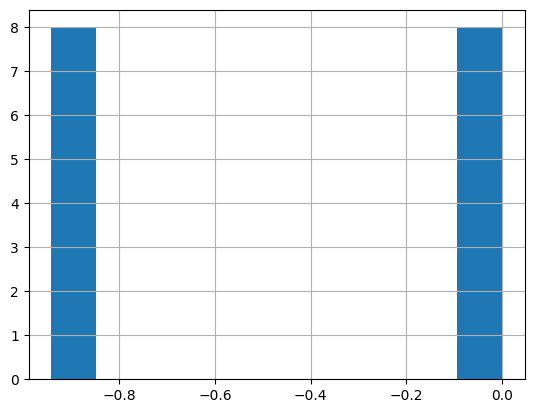

In [39]:
processed_data['EX4']['Screw Speed'].hist()

In [11]:
import matplotlib.pyplot as plt

pressure_timediffs = {}

for col in processed_data['EX1'].columns:

    for ext_num in [1, 2, 3, 4]:        
        extruder = f'EX{ext_num}'
        ex_data = processed_data[extruder][col]

        if col == 'Extruder Pressure':
            pressure_timediffs[extruder] = ex_data.index.to_series().diff()
            break
        
        plt.hist(ex_data.values)
        plt.title(f'{col} for {extruder}')
        plt.show()
    
    break
#    ex_data = processed_data['EX2'][col]
#    plt.hist(ex1_data.values)
#   plt.title(f'{col} for EX1')
#    plt.show()

In [12]:
import matplotlib.pyplot as plt

time_diffs_in_seconds = pressure_timediffs['EX1'].apply(lambda x: x.total_seconds())


In [13]:
time_diffs_in_minutes = time_diffs_in_seconds / 60

In [18]:
max_timediffs = time_diffs_in_minutes.rolling('48H').max()
max_timediffs.name = 'backward looking 48H'

In [19]:
max_timediffs_forward = time_diffs_in_minutes[::-1].rolling('1H').max()
max_timediffs_forward.name = 'forward looking 1H'

In [20]:
test = pd.merge(max_timediffs, max_timediffs_forward, left_index=True, right_index=True, how='outer')

In [21]:
test.head()

,backward looking 48H,forward looking 1H
2023-07-16 04:50:50,NaN,0.066667
2023-07-16 04:50:51,0.016667,0.066667
2023-07-16 04:50:52,0.016667,0.066667
2023-07-16 04:50:53,0.016667,0.066667
2023-07-16 04:50:54,0.016667,0.066667


In [23]:
good_data = test[
    (test['backward looking 48H'] <= 15) & \
    (test['forward looking 1H'] <= 15)
]

In [25]:
len(good_data) / len(test)

0.924676696136049

In [ ]:
max_timediffs[(max_timediffs < 100) & (max_timediffs > 10)].hist()

In [ ]:
max_timediffs[(max_timediffs < 15)].hist()

In [94]:
test = max_timediffs[max_timediffs < 10]

In [95]:
test

2023-08-03 08:53:31    31.083333
2023-08-03 08:53:32    31.083333
2023-08-03 08:53:33    31.083333
2023-08-03 08:53:34    31.083333
2023-08-03 08:53:40    31.083333
                         ...    
2023-11-23 21:52:39    21.866667
2023-11-23 21:52:41    21.866667
2023-11-23 21:52:42    21.866667
2023-11-23 21:52:43    21.866667
2023-11-23 21:52:47    21.866667
Length: 262451, dtype: float64

In [79]:
pressure_timediffs['EX1'].max()

Timedelta('0 days 04:13:15')

<Axes: >

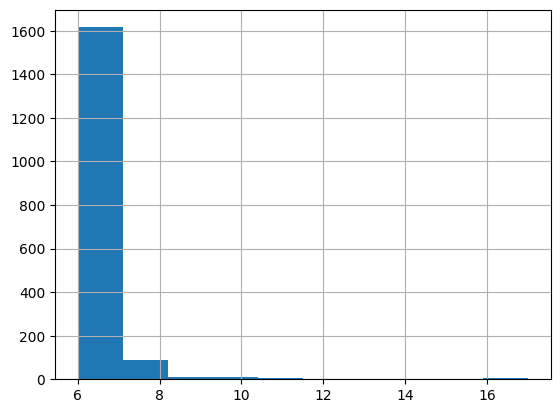

In [77]:
time_diffs_in_seconds[(time_diffs_in_seconds < 20) & (time_diffs_in_seconds > 5)].hist()

In [66]:
time_diffs_in_seconds.iloc[1]

1.0

In [64]:
time_diffs_in_minutes

2023-07-16 04:50:50         NaN
2023-07-16 04:50:51    0.016667
2023-07-16 04:50:52    0.016667
2023-07-16 04:50:53    0.016667
2023-07-16 04:50:54    0.016667
                         ...   
2024-01-14 04:50:45    0.016667
2024-01-14 04:50:46    0.016667
2024-01-14 04:50:47    0.016667
2024-01-14 04:50:48    0.016667
2024-01-14 04:50:49    0.016667
Length: 12895531, dtype: float64

In [56]:
test = time_diffs_in_minutes[time_diffs_in_minutes < 10]
test.value_counts()

0.016667    10502656
0.033333     2158848
0.050000      186231
0.066667       41093
0.083333        4831
0.100000        1391
0.116667         225
0.133333          88
0.166667          12
0.150000          11
0.183333           5
0.333333           4
0.350000           4
0.200000           3
3.233333           2
0.233333           2
0.266667           2
0.250000           2
0.500000           2
6.250000           2
0.216667           2
2.233333           2
0.466667           2
0.283333           2
3.633333           1
7.333333           1
3.516667           1
1.450000           1
1.650000           1
1.600000           1
8.616667           1
0.383333           1
1.983333           1
5.933333           1
4.450000           1
6.933333           1
3.583333           1
6.850000           1
8.516667           1
2.766667           1
0.650000           1
0.700000           1
1.433333           1
1.466667           1
1.033333           1
1.183333           1
3.300000           1
1.133333     

In [55]:
test2

<Axes: >

<Axes: >

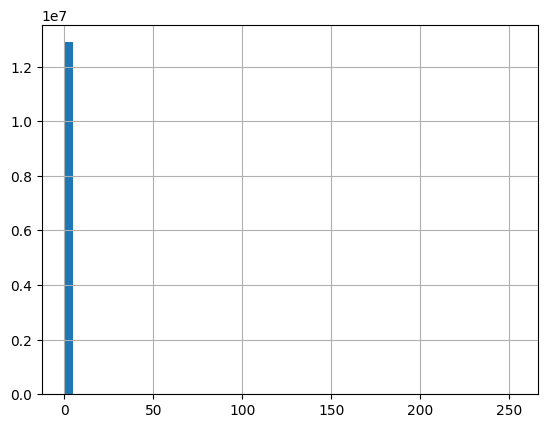

In [51]:
time_diffs_in_minutes.hist(bins=50)

In [46]:
processed_data['EX1'][processed_data[].index

DatetimeIndex(['2023-07-16 04:50:50', '2023-07-16 04:50:51',
               '2023-07-16 04:50:52', '2023-07-16 04:50:53',
               '2023-07-16 04:50:54', '2023-07-16 04:50:55',
               '2023-07-16 04:50:56', '2023-07-16 04:50:57',
               '2023-07-16 04:50:58', '2023-07-16 04:50:59',
               ...
               '2024-01-14 04:50:39', '2024-01-14 04:50:40',
               '2024-01-14 04:50:41', '2024-01-14 04:50:42',
               '2024-01-14 04:50:44', '2024-01-14 04:50:45',
               '2024-01-14 04:50:46', '2024-01-14 04:50:47',
               '2024-01-14 04:50:48', '2024-01-14 04:50:49'],
              dtype='datetime64[ns]', length=12895531, freq=None)

In [58]:
series_list[3]

PT_5362.PV.TIME
2023-07-16 04:50:50    1799.374023
2023-07-16 04:50:51    1746.228516
2023-07-16 04:50:52    1824.406250
2023-07-16 04:50:53    1758.250000
2023-07-16 04:50:55    1842.168945
                          ...     
NaT                            NaN
NaT                            NaN
NaT                            NaN
NaT                            NaN
NaT                            NaN
Name: PT_5362.PV, Length: 12505849, dtype: float64

In [62]:
processed_data['EX4'].nlargest(10, 'Extruder Thrust ')

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2024-01-05 08:05:02,3010.487305,NaN,NaN,36.640137,103.625000,NaN,NaN,NaN
2023-10-03 18:24:31,-60.787598,NaN,NaN,8.821228,97.165123,NaN,0.00,NaN
2023-10-09 08:49:52,3529.117188,NaN,NaN,NaN,62.665436,NaN,0.96,NaN
2023-10-09 08:44:11,3415.941406,NaN,NaN,NaN,62.465347,NaN,0.94,NaN
2023-10-09 08:52:12,3377.107422,NaN,NaN,NaN,62.296600,NaN,NaN,NaN
2023-10-09 09:01:58,NaN,NaN,NaN,NaN,62.252716,NaN,0.98,NaN
2023-10-09 08:49:57,3273.968750,NaN,NaN,NaN,62.187637,NaN,0.98,NaN
2023-10-09 08:52:20,3450.044922,NaN,NaN,NaN,62.166412,NaN,NaN,NaN
2023-10-09 08:50:06,2956.879883,NaN,NaN,NaN,62.158875,NaN,NaN,NaN
2023-10-09 09:02:20,3122.936523,NaN,NaN,NaN,62.155342,NaN,NaN,NaN


In [66]:
processed_data['EX1'].nlargest(10, 'Extruder Die Temp')

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-08-04 06:22:33,-111.273438,-0.250732,NaN,10752.037109,-0.808685,NaN,NaN,NaN
2023-09-06 03:09:52,4877.314453,NaN,NaN,10751.794922,NaN,0.48,NaN,NaN
2023-09-06 03:09:50,4697.460938,NaN,NaN,10751.779297,NaN,NaN,NaN,NaN
2023-08-03 14:39:26,175.093750,14.745537,NaN,10751.484375,-0.825287,NaN,NaN,NaN
2023-08-03 14:34:04,342.470703,9.730656,NaN,10751.369141,-0.821823,NaN,NaN,NaN
2023-08-03 14:38:08,NaN,NaN,NaN,10751.099609,-0.820312,NaN,NaN,NaN
2023-08-04 07:26:07,NaN,NaN,NaN,10751.093750,NaN,NaN,1.09,NaN
2023-07-31 02:48:32,4231.851562,NaN,NaN,10750.767578,NaN,NaN,0.99,NaN
2023-08-03 14:29:04,479.480469,14.725006,NaN,10750.755859,NaN,NaN,NaN,NaN
2023-07-31 02:47:19,4430.523438,NaN,NaN,10750.724609,53.041138,NaN,NaN,NaN


In [55]:
processed_data['EX4'].nlargest(10, processed_data['EX4'].columns).head(100)

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-08-09 16:10:17,6563.419922,NaN,NaN,NaN,NaN,NaN,0.96,NaN
2023-11-06 00:25:17,6450.701172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-21 09:48:18,6419.167969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-06 00:26:21,6416.785156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-07 07:48:32,6294.439453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-07 11:48:01,6179.496094,NaN,NaN,NaN,0.854462,NaN,NaN,NaN
2023-11-06 00:26:01,5966.212891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-07 07:16:23,5895.904297,NaN,NaN,NaN,0.228897,NaN,NaN,NaN
2023-11-06 00:26:58,5846.673828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-09 09:23:25,5542.947266,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
processed_data['EX4'].columns

Index(['Extruder Pressure', 'Screw Speed Output', 'Screw Speed',
       'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)',
       'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)'],
      dtype='object')

In [75]:
test_data = processed_data['EX4']

In [76]:
test_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:50,1799.374023,NaN,NaN,NaN,37.652023,NaN,1.07,NaN
2023-07-16 04:50:51,1746.228516,NaN,NaN,NaN,36.429214,NaN,NaN,NaN
2023-07-16 04:50:52,1824.406250,NaN,NaN,NaN,37.902496,NaN,1.03,NaN
2023-07-16 04:50:53,1758.250000,NaN,NaN,NaN,36.522247,NaN,NaN,NaN
2023-07-16 04:50:54,NaN,NaN,NaN,NaN,37.670731,NaN,NaN,NaN


In [ ]:
#------------------random scribbles----------------------------

In [28]:
test = list(field_mappings[extruder].values())
test.remove('Date and Time')
print(test)

['Extruder Pressure', 'Screw Speed Output', 'Screw Speed', 'Extruder Die Temp', 'Extruder Thrust ', 'Feed Screw Current (Amps)', 'Discharge Conveyor Current (Amps)', 'Discharge Conveyor Speed (%)']


In [41]:
%%time

#inp_filename = 'EX1-6-month.csv'
data_dir = 'data'

field_mappings = {}
#time_
ex_data = {}
processed_data = {}
collected_series = {}

for extruder in ['EX1', 'EX2', 'EX3', 'EX4']:
    print(extruder)
    ex_name_mapping = pd.read_csv(os.path.join(data_dir, f'{extruder}-6-month.csv'), 
                               delimiter='\t',
                               encoding='utf-16',
                               nrows=1)

    field_mappings[extruder] = dict(zip(ex_name_mapping.iloc[0], ex_name_mapping.columns ))
    

    #print(extruder)
    #print(name_mappings[extruder])


   # for field_key in name_mappings[extruder]:

    col_mapping = {key : key.split(' (')[0] for key, value in field_mappings[extruder].items() if key != 'Time'}

#    for raw_colname in col_mapping.keys():
#        field_mappings[extruder + '_col2col'] = 

    field_mappings[extruder + '_column_map'] = col_mapping
    
    raw_fieldnames = sorted(col_mapping.values())
    time_keys = [fieldname + '.TIME' for fieldname in raw_fieldnames]
        
    #print(keys_filtered)
    #print(time_keys)

    keys_of_interest = sorted(raw_fieldnames + time_keys)

    ex_data[extruder] = raw_data[keys_of_interest]

    processed_df, series_list = merge_data_with_time(
        ex_data[extruder], verbose=False, window=None, get_series_list=True
    )

    for raw_colname in col_mapping.keys():
        processed_df[field_mappings[extruder][raw_colname]] = processed_df[field_mappings[f'{extruder}_column_map'][raw_colname]]
        
    processed_colnames = list(field_mappings[extruder].values())
    processed_colnames.remove('Date and Time')
    processed_df = processed_df[processed_colnames]
    
    processed_data[extruder] = processed_df
    collected_series[extruder] = series_list
    
    for tk in time_keys:
        ex_data[extruder][tk] = pd.to_datetime(ex_data[extruder][tk])

        field_key = tk.replace('.TIME', '')

    print()
    #ex_data[extruder] = raw_data[keys_filtered]

EX1

EX2

EX3

EX4

CPU times: user 1min 46s, sys: 7.15 s, total: 1min 53s
Wall time: 1min 53s


In [42]:
processed_data['EX1'].head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:50,4070.291016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:51,3941.896484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 04:50:52,4167.226562,NaN,NaN,NaN,NaN,NaN,0.94,NaN
2023-07-16 04:50:53,3930.353516,NaN,NaN,NaN,49.097092,NaN,0.98,NaN
2023-07-16 04:50:54,4192.916016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
for col in processed_data['EX1'].columns:
    print(col)
    print(processed_data['EX1'][processed_data['EX1'][col].notnull()].index.min())

Extruder Pressure
2023-07-16 04:50:50
Screw Speed Output
2023-07-16 09:19:27
Screw Speed
2023-07-17 16:06:15
Extruder Die Temp
2023-07-16 05:23:22
Extruder Thrust 
2023-07-16 04:50:53
Feed Screw Current (Amps)
2023-07-16 04:51:02
Discharge Conveyor Current (Amps)
2023-07-16 04:50:52
Discharge Conveyor Speed (%)
2023-07-17 16:06:18


In [12]:
ex_name_mapping

,Date and Time,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
0,Time,PT_5362.PV (psi),SIC_5360.OUT (%),ST_5362.PV (RPM),TT_5362.PV (°F),WT_5362.PV (%),PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.I...,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.I...,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.S...


In [18]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [13]:
processed_data['EX4'].head(1)

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,PT_5362.PV,SIC_5360.OUT,ST_5362.PV,TT_5362.PV,WT_5362.PV
2023-07-16 04:50:00,3.41,1.07,NaN,1801.763074,NaN,NaN,NaN,37.122286


In [17]:
for ex in processed_data.keys():
    processed_df = processed_data[ex]
    print(ex)
    print(processed_df.isnull().sum()/len(processed_df))
    #print(processed_data[ex].head(1))
    print()

In [11]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [73]:
test = processed_df[processed_df['ST_5347.PV'].notnull()]
test.sort_index().index[:50]

DatetimeIndex(['2023-07-16 09:19:00', '2023-07-16 17:09:00',
               '2023-07-17 01:00:00', '2023-07-17 08:50:00',
               '2023-07-17 16:05:00', '2023-07-17 16:06:00',
               '2023-07-17 16:07:00', '2023-07-17 23:58:00',
               '2023-07-18 07:48:00', '2023-07-18 15:38:00',
               '2023-07-18 23:29:00', '2023-07-19 07:19:00',
               '2023-07-19 15:10:00', '2023-07-19 23:00:00',
               '2023-07-20 06:50:00', '2023-07-20 11:09:00',
               '2023-07-20 12:29:00', '2023-07-20 12:30:00',
               '2023-07-20 20:20:00', '2023-07-21 04:10:00',
               '2023-07-21 12:01:00', '2023-07-21 19:51:00',
               '2023-07-22 03:41:00', '2023-07-22 11:32:00',
               '2023-07-22 19:22:00', '2023-07-23 03:13:00',
               '2023-07-23 11:03:00', '2023-07-23 18:53:00',
               '2023-07-24 02:44:00', '2023-07-24 10:34:00',
               '2023-07-24 18:25:00', '2023-07-25 02:15:00',
               '2023-07-

In [75]:
test.head(5)

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PT_5347.PV,SIC_5345.OUT,ST_5347.PV,TT_5347.PV,WT_5347.PV
2023-07-16 09:19:00,2.7350,0.970741,NaN,4067.157785,NaN,27.800705,NaN,48.920944
2023-07-16 17:09:00,2.7550,0.947826,NaN,4107.848800,NaN,27.796013,NaN,50.515979
2023-07-17 01:00:00,NaN,0.985714,NaN,4229.140625,NaN,27.820351,NaN,51.048469
2023-07-17 08:50:00,5.7975,0.967391,NaN,4159.743207,NaN,27.828751,NaN,50.613756
2023-07-17 16:05:00,NaN,0.946667,NaN,4411.497389,NaN,27.822044,350.408203,50.505443


In [30]:
field_mappings

{'EX1': {'Time': 'Date and Time',
  'PT_5347.PV (psi)': 'Extruder Pressure',
  'ST_5347.PV (RPM)': 'Screw Speed Output',
  'SIC_5345.OUT (%)': 'Screw Speed',
  'TT_5347.PV (°F)': 'Extruder Die Temp',
  'WT_5347.PV (%)': 'Extruder Thrust ',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'},
 'EX1_column_map': {'PT_5347.PV (psi)': 'PT_5347.PV',
  'ST_5347.PV (RPM)': 'ST_5347.PV',
  'SIC_5345.OUT (%)': 'SIC_5345.OUT',
  'TT_5347.PV (°F)': 'TT_5347.PV',
  'WT_5347.PV (%)': 'WT_5347.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV',
  'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV',
  'PJ00

In [ ]:
for col in processed_data['EX1'].columns:
    print(f'{col}')


In [67]:
(processed_data['EX1'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       8
Screw Speed                              1
Extruder Die Temp                        8
Extruder Thrust                          8
Feed Screw Current (Amps)            33294
Discharge Conveyor Current (Amps)       41
Discharge Conveyor Speed (%)             1
dtype: int64

In [68]:
(processed_data['EX2'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       1
Screw Speed                              8
Extruder Die Temp                        8
Extruder Thrust                          8
Feed Screw Current (Amps)            35246
Discharge Conveyor Current (Amps)       28
Discharge Conveyor Speed (%)             1
dtype: int64

In [69]:
(processed_data['EX3'] == 0).sum()

Extruder Pressure                        6
Screw Speed Output                       1
Screw Speed                              6
Extruder Die Temp                        6
Extruder Thrust                          6
Feed Screw Current (Amps)            34330
Discharge Conveyor Current (Amps)       27
Discharge Conveyor Speed (%)             1
dtype: int64

In [70]:
(processed_data['EX4'] == 0).sum()

Extruder Pressure                        8
Screw Speed Output                       1
Screw Speed                              1
Extruder Die Temp                        8
Extruder Thrust                          7
Feed Screw Current (Amps)            28727
Discharge Conveyor Current (Amps)     1222
Discharge Conveyor Speed (%)             1
dtype: int64

In [71]:
processed_data['EX1'][processed_data['EX1']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,0.0,6.952558e-310,NaN,NaN,0.0,0.0,NaN
2023-09-05 07:01:12,0.0,0.0,6.952558e-310,0.0,NaN,0.0,0.0,NaN
2023-09-23 08:02:39,0.0,0.0,6.952558e-310,0.0,NaN,0.0,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2023-11-07 06:30:00,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,NaN
2023-11-23 07:59:47,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,0.0,6.952558e-310,0.0,0.0,0.0,0.0,NaN
2024-01-12 17:40:25,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,NaN


In [72]:
processed_data['EX2'][processed_data['EX2']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,6.952558e-310,0.0,NaN,NaN,0.0,0.000000e+00,NaN
2023-09-05 07:01:12,0.0,6.952558e-310,0.0,0.0,NaN,0.0,0.000000e+00,NaN
2023-09-23 08:02:39,0.0,6.952558e-310,0.0,0.0,NaN,0.0,0.000000e+00,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,0.0,0.0,0.0,0.0,0.000000e+00,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,0.0,0.0,0.0,0.0,0.000000e+00,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,0.0,0.0,0.0,0.0,6.952558e-310,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,NaN


In [73]:
processed_data['EX3'][processed_data['EX3']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-09-23 08:02:39,0.0,6.952558e-310,0.0,0.0,NaN,0.000000e+00,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,0.0,0.0,0.0,6.952558e-310,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,0.0,0.0,0.0,0.000000e+00,0.0,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,NaN


In [74]:
processed_data['EX4'][processed_data['EX4']['Extruder Pressure'] == 0]

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 16:06:15,0.0,6.952558e-310,6.952558e-310,NaN,NaN,0.0,0.0,NaN
2023-09-05 07:01:12,0.0,6.952558e-310,6.952558e-310,0.0,NaN,0.0,0.0,NaN
2023-09-23 08:02:39,0.0,6.952558e-310,6.952558e-310,0.0,NaN,0.0,0.0,6.952558e-310
2023-10-03 18:24:53,0.0,NaN,6.952558e-310,0.0,0.000000e+00,0.0,0.0,NaN
2023-11-07 06:30:00,0.0,6.952558e-310,6.952558e-310,0.0,0.000000e+00,0.0,0.0,NaN
2023-11-23 07:59:47,0.0,6.952558e-310,6.952558e-310,0.0,0.000000e+00,0.0,0.0,6.952558e-310
2024-01-12 17:09:19,0.0,6.952558e-310,6.952558e-310,0.0,6.952558e-310,0.0,0.0,NaN
2024-01-12 17:40:25,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,NaN


In [30]:
ex_data['EX1'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME,PT_5347.PV,PT_5347.PV.TIME,SIC_5345.OUT,SIC_5345.OUT.TIME,ST_5347.PV,ST_5347.PV.TIME,TT_5347.PV,TT_5347.PV.TIME,WT_5347.PV,WT_5347.PV.TIME
0,5.56,2023-07-16 04:51:02,0.94,2023-07-16 04:50:52,6.952558e-310,2023-07-17 16:06:18,4070.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.800705,2023-07-16 09:19:27,334.851562,2023-07-16 05:23:22,49.097092,2023-07-16 04:50:53
1,0.00,2023-07-16 04:51:03,0.98,2023-07-16 04:50:53,7.000000e+01,2023-07-17 16:07:48,3941.896484,2023-07-16 04:50:51,3.500000e+01,2023-07-17 16:07:46,27.796013,2023-07-16 17:09:49,335.320312,2023-07-16 06:17:56,48.470383,2023-07-16 04:50:56
2,5.34,2023-07-16 04:53:45,0.96,2023-07-16 04:50:55,8.500000e+01,2023-08-03 09:32:37,4167.226562,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:28:38,27.820351,2023-07-17 01:00:20,337.341797,2023-07-16 07:31:15,48.842682,2023-07-16 04:51:09
3,5.57,2023-07-16 04:53:47,1.02,2023-07-16 04:50:56,1.000000e+02,2023-08-03 09:51:02,3930.353516,2023-07-16 04:50:53,NaN,NaT,27.828751,2023-07-17 08:50:49,341.666016,2023-07-16 10:29:42,48.621353,2023-07-16 04:51:22
4,5.51,2023-07-16 04:55:14,1.01,2023-07-16 04:50:57,NaN,NaT,4192.916016,2023-07-16 04:50:54,NaN,NaT,27.822044,2023-07-17 16:05:54,344.843750,2023-07-16 11:05:26,48.816040,2023-07-16 04:51:35


In [31]:
ex_data['EX1'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME,PT_5347.PV,PT_5347.PV.TIME,SIC_5345.OUT,SIC_5345.OUT.TIME,ST_5347.PV,ST_5347.PV.TIME,TT_5347.PV,TT_5347.PV.TIME,WT_5347.PV,WT_5347.PV.TIME
0,5.56,2023-07-16 04:51:02,0.94,2023-07-16 04:50:52,6.952558e-310,2023-07-17 16:06:18,4070.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.800705,2023-07-16 09:19:27,334.851562,2023-07-16 05:23:22,49.097092,2023-07-16 04:50:53
1,0.00,2023-07-16 04:51:03,0.98,2023-07-16 04:50:53,7.000000e+01,2023-07-17 16:07:48,3941.896484,2023-07-16 04:50:51,3.500000e+01,2023-07-17 16:07:46,27.796013,2023-07-16 17:09:49,335.320312,2023-07-16 06:17:56,48.470383,2023-07-16 04:50:56
2,5.34,2023-07-16 04:53:45,0.96,2023-07-16 04:50:55,8.500000e+01,2023-08-03 09:32:37,4167.226562,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:28:38,27.820351,2023-07-17 01:00:20,337.341797,2023-07-16 07:31:15,48.842682,2023-07-16 04:51:09
3,5.57,2023-07-16 04:53:47,1.02,2023-07-16 04:50:56,1.000000e+02,2023-08-03 09:51:02,3930.353516,2023-07-16 04:50:53,NaN,NaT,27.828751,2023-07-17 08:50:49,341.666016,2023-07-16 10:29:42,48.621353,2023-07-16 04:51:22
4,5.51,2023-07-16 04:55:14,1.01,2023-07-16 04:50:57,NaN,NaT,4192.916016,2023-07-16 04:50:54,NaN,NaT,27.822044,2023-07-17 16:05:54,344.843750,2023-07-16 11:05:26,48.816040,2023-07-16 04:51:35


In [32]:
ex_data['EX1'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12505849 entries, 0 to 12505848
Data columns (total 16 columns):
 #   Column                                                          Dtype         
---  ------                                                          -----         
 0   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV         float64       
 1   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV.TIME    datetime64[ns]
 2   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV         float64       
 3   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV.TIME    datetime64[ns]
 4   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT       float64       
 5   PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT.TIME  datetime64[ns]
 6   PT_5347.PV                                                      float64       
 7   PT_5347.PV.TIME                                                 datetime64[ns]
 8   SIC_5345.OUT                            

In [33]:
ex_data['EX2'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5350.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5410.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5410.OUT.TIME,PT_5352.PV,PT_5352.PV.TIME,SIC_5350.OUT,SIC_5350.OUT.TIME,ST_5352.PV,ST_5352.PV.TIME,TT_5352.PV,TT_5352.PV.TIME,WT_5352.PV,WT_5352.PV.TIME
0,5.66,2023-07-16 04:53:10,0.98,2023-07-16 04:53:18,6.952558e-310,2023-07-17 16:06:18,3206.291016,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,27.813858,2023-07-16 05:32:47,272.890625,2023-07-16 04:55:17,59.686783,2023-07-16 04:50:55
1,4.74,2023-07-16 04:53:11,0.97,2023-07-16 04:54:57,8.000000e+01,2023-07-17 16:07:48,3055.000000,2023-07-16 04:50:52,3.500000e+01,2023-07-17 16:07:46,27.783119,2023-07-16 13:29:18,274.255859,2023-07-16 05:02:58,59.433762,2023-07-16 04:51:11
2,4.70,2023-07-16 04:58:38,0.99,2023-07-16 04:54:59,8.500000e+01,2023-08-03 09:32:47,3165.830078,2023-07-16 04:50:53,2.500000e+01,2023-07-25 14:28:25,27.758209,2023-07-16 21:26:34,276.605469,2023-07-16 05:18:32,60.262482,2023-07-16 04:51:14
3,5.35,2023-07-16 04:58:40,0.98,2023-07-16 04:55:10,NaN,NaT,3026.894531,2023-07-16 04:50:54,5.000000e+01,2023-07-25 14:47:16,27.752220,2023-07-17 05:24:09,274.621094,2023-07-16 05:26:59,59.789719,2023-07-16 04:51:18
4,0.00,2023-07-16 04:58:41,0.98,2023-07-16 05:03:59,NaN,NaT,3201.855469,2023-07-16 04:50:55,1.000000e+02,2023-07-25 14:47:26,27.781960,2023-07-17 12:03:19,275.726562,2023-07-16 05:33:03,59.664200,2023-07-16 04:51:50


In [34]:
ex_data['EX3'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5355.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5415.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5415.OUT.TIME,PT_5357.PV,PT_5357.PV.TIME,SIC_5355.OUT,SIC_5355.OUT.TIME,ST_5357.PV,ST_5357.PV.TIME,TT_5357.PV,TT_5357.PV.TIME,WT_5357.PV,WT_5357.PV.TIME
0,6.952558e-310,2023-07-17 16:06:15,0.04,2023-07-17 15:36:23,6.952558e-310,2023-07-17 16:06:18,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:27,6.952558e-310,2023-07-17 16:06:27
1,0.000000e+00,2023-07-17 16:07:46,0.07,2023-07-17 15:36:24,8.000000e+01,2023-07-17 16:07:48,-2.718750e+02,2023-07-17 16:07:46,3.000000e+01,2023-07-17 16:07:46,-9.425001e-01,2023-07-17 16:07:46,-1.450000e+01,2023-07-17 16:07:46,-3.625000e+00,2023-07-17 16:07:46
2,NaN,NaT,0.00,2023-07-17 15:36:46,NaN,NaT,NaN,NaT,2.500000e+01,2023-07-25 14:28:06,NaN,NaT,NaN,NaT,NaN,NaT
3,NaN,NaT,0.07,2023-07-17 15:36:52,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
4,NaN,NaT,0.08,2023-07-17 15:45:49,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT


In [35]:
ex_data['EX4'].head()

,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5360.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5420.PV.TIME,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT,PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5420.OUT.TIME,PT_5362.PV,PT_5362.PV.TIME,SIC_5360.OUT,SIC_5360.OUT.TIME,ST_5362.PV,ST_5362.PV.TIME,TT_5362.PV,TT_5362.PV.TIME,WT_5362.PV,WT_5362.PV.TIME
0,4.99,2023-07-16 04:51:39,1.07,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:18,1799.374023,2023-07-16 04:50:50,6.952558e-310,2023-07-17 16:06:15,6.952558e-310,2023-07-17 16:06:15,8.323669,2023-07-16 05:04:36,37.652023,2023-07-16 04:50:50
1,5.24,2023-07-16 04:51:40,1.03,2023-07-16 04:50:52,7.000000e+01,2023-07-17 16:07:48,1746.228516,2023-07-16 04:50:51,7.500000e+01,2023-07-17 16:07:46,-9.425001e-01,2023-07-17 16:07:46,8.873474,2023-07-16 12:55:00,36.429214,2023-07-16 04:50:51
2,0.00,2023-07-16 04:51:41,1.10,2023-07-16 04:50:56,1.000000e+02,2023-07-20 12:09:44,1824.406250,2023-07-16 04:50:52,2.500000e+01,2023-07-25 14:27:40,NaN,NaT,8.811279,2023-07-16 20:45:25,37.902496,2023-07-16 04:50:52
3,6.53,2023-07-16 04:56:10,1.04,2023-07-16 04:51:00,7.000000e+01,2023-07-20 12:13:20,1758.250000,2023-07-16 04:50:53,3.500000e+01,2023-07-29 05:38:22,NaN,NaT,8.643921,2023-07-17 04:35:50,36.522247,2023-07-16 04:50:53
4,5.34,2023-07-16 04:56:11,1.08,2023-07-16 04:51:01,8.000000e+01,2023-07-24 14:09:02,1842.168945,2023-07-16 04:50:55,NaN,NaT,NaN,NaT,8.886841,2023-07-17 12:26:13,37.670731,2023-07-16 04:50:54


In [36]:
print(processed_data['EX1'].info())
processed_data['EX1'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  51895 non-null  float64
 1   Screw Speed Output                 734 non-null    float64
 2   Screw Speed                        16 non-null     float64
 3   Extruder Die Temp                  7149 non-null   float64
 4   Extruder Thrust                    51816 non-null  float64
 5   Feed Screw Current (Amps)          51856 non-null  float64
 6   Discharge Conveyor Current (Amps)  37985 non-null  float64
 7   Discharge Conveyor Speed (%)       19 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,4057.106586,NaN,NaN,NaN,48.796735,4.1175,0.969687,NaN
2023-07-16 04:55:00,3996.547541,NaN,NaN,NaN,48.589401,4.9770,0.976985,NaN
2023-07-16 05:00:00,3998.819069,NaN,NaN,NaN,48.614656,3.8300,0.971379,NaN
2023-07-16 05:05:00,4076.056384,NaN,NaN,NaN,49.006142,3.6900,0.971888,NaN
2023-07-16 05:10:00,4133.956836,NaN,NaN,NaN,49.074539,4.5060,0.970986,NaN


In [37]:
print(processed_data['EX2'].info())
processed_data['EX2'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  49288 non-null  float64
 1   Screw Speed Output                 29 non-null     float64
 2   Screw Speed                        1474 non-null   float64
 3   Extruder Die Temp                  7849 non-null   float64
 4   Extruder Thrust                    49277 non-null  float64
 5   Feed Screw Current (Amps)          46429 non-null  float64
 6   Discharge Conveyor Current (Amps)  16380 non-null  float64
 7   Discharge Conveyor Speed (%)       18 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,3221.500208,NaN,NaN,NaN,60.076366,5.200,0.980000,NaN
2023-07-16 04:55:00,3147.111020,NaN,NaN,272.890625,59.512808,3.350,0.980000,NaN
2023-07-16 05:00:00,3217.413433,NaN,NaN,274.255859,59.979941,4.710,0.995000,NaN
2023-07-16 05:05:00,3310.032572,NaN,NaN,NaN,60.364799,3.550,0.984286,NaN
2023-07-16 05:10:00,3292.845131,NaN,NaN,NaN,60.667564,2.345,0.975000,NaN


In [38]:
print(processed_data['EX3'].info())
processed_data['EX3'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52000 entries, 2023-07-17 15:35:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  32081 non-null  float64
 1   Screw Speed Output                 16 non-null     float64
 2   Screw Speed                        611 non-null    float64
 3   Extruder Die Temp                  364 non-null    float64
 4   Extruder Thrust                    32074 non-null  float64
 5   Feed Screw Current (Amps)          31614 non-null  float64
 6   Discharge Conveyor Current (Amps)  3961 non-null   float64
 7   Discharge Conveyor Speed (%)       16 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-17 15:35:00,NaN,NaN,NaN,NaN,NaN,NaN,0.045,NaN
2023-07-17 15:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-17 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,0.040,NaN
2023-07-17 15:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-17 15:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
print(processed_data['EX4'].info())
processed_data['EX4'].head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52417 entries, 2023-07-16 04:50:00 to 2024-01-14 04:50:00
Freq: 5T
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Extruder Pressure                  50140 non-null  float64
 1   Screw Speed Output                 36 non-null     float64
 2   Screw Speed                        13 non-null     float64
 3   Extruder Die Temp                  878 non-null    float64
 4   Extruder Thrust                    43990 non-null  float64
 5   Feed Screw Current (Amps)          46559 non-null  float64
 6   Discharge Conveyor Current (Amps)  41932 non-null  float64
 7   Discharge Conveyor Speed (%)       38 non-null     float64
dtypes: float64(8)
memory usage: 3.6 MB
None


,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%)
2023-07-16 04:50:00,1801.763074,NaN,NaN,NaN,37.122286,3.410000,1.070000,NaN
2023-07-16 04:55:00,1792.386690,NaN,NaN,NaN,37.019737,4.675000,1.070756,NaN
2023-07-16 05:00:00,1805.653592,NaN,NaN,8.323669,37.135512,4.131667,1.067364,NaN
2023-07-16 05:05:00,1787.643932,NaN,NaN,NaN,36.980019,5.272500,1.069709,NaN
2023-07-16 05:10:00,1789.340884,NaN,NaN,NaN,37.037894,3.772500,1.071493,NaN


In [17]:
ex1_field_mapping = 

In [18]:
ex1_field_mapping

{'Time': 'Date and Time',
 'PT_5347.PV (psi)': 'Extruder Pressure',
 'ST_5347.PV (RPM)': 'Screw Speed Output',
 'SIC_5345.OUT (%)': 'Screw Speed',
 'TT_5347.PV (°F)': 'Extruder Die Temp',
 'WT_5347.PV (%)': 'Extruder Thrust ',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5345.PV (Amps)': 'Feed Screw Current (Amps)',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.IT_5405.PV (Amps)': 'Discharge Conveyor Current (Amps)',
 'PJ001959_EWS:RSLinx Enterprise:PJ001992_SITE.SIC_5405.OUT (%)': 'Discharge Conveyor Speed (%)'}

In [10]:
ex1_code_names = ex1_raw_data.iloc[0]
ex1_raw_data = ex1_raw_data.iloc[1:]

#test = ex1_raw_data.infer_objects()

#for types in zip(ex1_raw_data.dtypes, test.dtypes):
#    print(types)

ex1_raw_data.dtypes



NameError: name 'ex1_raw_data' is not defined

In [ ]:
ex1_raw_data.head(2)

In [ ]:
ex1_raw_data.info()

In [ ]:
has_null_vals = ex1_raw_data.apply(lambda row: '<null>' in row.values, axis=1)

In [ ]:
ex1_raw_data.iloc[0]

In [ ]:
test = ex1_raw_data[has_null_vals]

In [ ]:
len(t)

In [ ]:
for t in test.columns:
    print(test[t].value_counts())